Follow this instruction:

https://www.kaggle.com/dlarionov

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

In [2]:
df_shops = pd.read_csv('data/shops.csv')
df_categories = pd.read_csv('data/item_categories.csv')
df_train = pd.read_csv('data/sales_train.csv')
# set index to ID to avoid droping it later
df_test  = pd.read_csv('data/test.csv').set_index('ID')

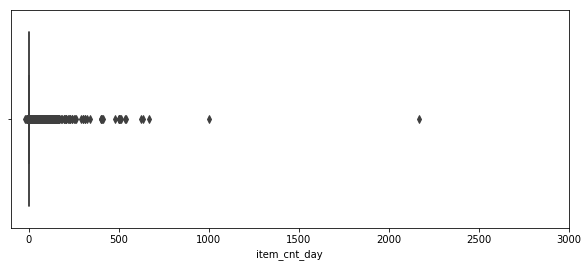

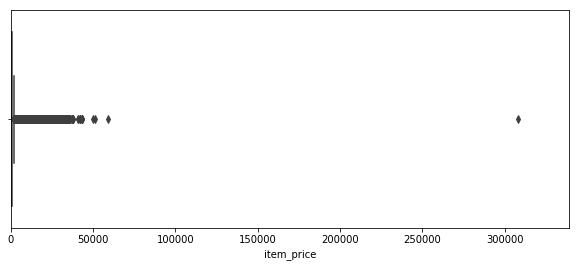

In [3]:
# Check Outliers

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df_train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(df_train.item_price.min(), df_train.item_price.max()*1.1)
sns.boxplot(x=df_train.item_price)

In [4]:
df_train = df_train[df_train.item_price<100000]
df_train = df_train[df_train.item_cnt_day<1001]

In [5]:
df_train.loc[df_train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [6]:
special_mean = df_train[(df_train.shop_id==32)&(df_train.item_id==2973)
         &(df_train.date_block_num==4)&(df_train.item_price>0)].item_price.mean()

In [7]:
df_train.loc[df_train.item_price < 0, 'item_price'] = special_mean

In [8]:
# Жуковский ул. Чкалова 39м²
df_train.loc[df_train.shop_id == 10, 'shop_id'] = 11
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

In [9]:
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'
df_shops['city_code'] = LabelEncoder().fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id','city_code']]

In [10]:
df_cats = pd.read_csv('data/item_categories.csv')

df_cats['split'] = df_cats['item_category_name'].str.split('-')
df_cats['type'] = df_cats['split'].map(lambda x: x[0].strip())
df_cats['type_code'] = LabelEncoder().fit_transform(df_cats['type'])
# if subtype is nan then type
df_cats['subtype'] = df_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_cats['subtype_code'] = LabelEncoder().fit_transform(df_cats['subtype'])
df_cats = df_cats[['item_category_id','type_code', 'subtype_code']]

In [11]:
df_items = pd.read_csv('data/items.csv')
df_items.drop(['item_name'], axis=1, inplace=True)

In [12]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = df_train[df_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

In [13]:
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [14]:
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [15]:
time.time()

1594130083.380459

In [16]:
df_train['revenue'] = df_train['item_price'] *  df_train['item_cnt_day']
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [17]:
ts = time.time()
group = df_train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().reset_index()
group = group.rename(columns={'item_cnt_day':'item_cnt_month'})

matrix1 = pd.merge(matrix, group, on=cols, how='left')
matrix1['item_cnt_month'] = (matrix1['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

6.2902820110321045

In [18]:
matrix = matrix1

# Test set

In [19]:
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)

In [20]:
ts = time.time()
matrix = pd.concat([matrix, df_test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.08335089683532715

## Shops/Items/Cats features

In [21]:
ts = time.time()
matrix = pd.merge(matrix, df_shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, df_items, on=['item_id'], how='left')
matrix = pd.merge(matrix, df_categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
#matrix['type_code'] = matrix['type_code'].astype(np.int8)
#matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

4.908504962921143

In [22]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_category_name
0,0,0,19,0.0,29,40,Кино - DVD
1,0,0,27,0.0,29,19,Игры - PS3
2,0,0,28,0.0,29,30,Игры PC - Стандартные издания
3,0,0,29,0.0,29,23,Игры - XBOX 360
4,0,0,32,6.0,29,40,Кино - DVD


## Traget lags

In [24]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [25]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

43.07166290283203

In [ ]:
#tmp = matrix[['date_block_num','shop_id','item_id','item_cnt_month']]

In [ ]:
#shifted = tmp.copy()
#shifted.columns = ['date_block_num','shop_id','item_id', 'item_cnt_month'+'_lag_'+str(2)]
#shifted['date_block_num'] += 2

In [ ]:
#pd.merge(matrix, shifted, on=['date_block_num','shop_id','item_id'], how='left')

In [ ]:
#matrix[matrix['date_block_num'] ==2]

## Mean encoded features

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.2250497341156

In [27]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,Кино - DVD,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,Игры - PS3,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,Игры PC - Стандартные издания,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,Игры - XBOX 360,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,Кино - DVD,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

52.67879319190979

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

59.4084689617157

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.501204013824463

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.789496183395386

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.487009048461914

In [33]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

34.764588832855225

## Trend features

In [34]:
ts = time.time()
group = df_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = df_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

In [ ]:
#matrix = matrix.drop('item_avg_item_price_x',axis=1)
#matrix = matrix.rename(columns={'item_avg_item_price_y':'item_avg_item_price'})

In [35]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [36]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) \
         / matrix['item_avg_item_price']
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [ ]:
#matrix['date_item_avg_item_price_lag_'+str(3)] - matrix['item_avg_item_price']

In [ ]:
#matrix

In [38]:
ts = time.time()
group = df_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

39.990715742111206

In [39]:
matrix['month'] = matrix['date_block_num'] % 12

In [40]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [41]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

2387.1197957992554

In [42]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

2099.6833889484406

In [43]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

3.723242998123169

In [44]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

5.439941883087158

In [45]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

6.330467224121094

In [46]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'item_category_name', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_1', 'date_item_city_avg_item_cnt_lag_1',
       'item_avg_item_price', 'date_item_avg_item_price',
       'date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2',
       'date_item_avg_item_price_lag_3', 'date_item_avg_item_price_lag_

In [47]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del df_items
del df_shops
del df_categories
del df_train
# leave test for submission
gc.collect();

# XGBoost

In [48]:
data = pd.read_pickle('data.pkl')

In [50]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    #'type_code',
    #'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [51]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [52]:
del data
gc.collect();

In [53]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:59:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:00] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.1284	validation_1-rmse:1.12159
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08987	validation_1-rmse:1.08519
[2]	validation_0-rmse:1.05842	validation_1-rmse:1.05709
[3]	validation_0-rmse:1.01606	validation_1-rmse:1.02988
[4]	validation_0-rmse:0.988487	validation_1-rmse:1.01041
[5]	validation_0-rmse:0.966394	validation_1-rmse:0.992957
[6]	validation_0-rmse:0.948588	validation_1-rmse:0.978123
[7]	validation_0-rmse:0.9286	validation_1-rmse:0.966874
[8]	validation_0-rmse:0.914858	validation_1-rmse:0.957379
[9]	validati

1936.5831751823425

In [55]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

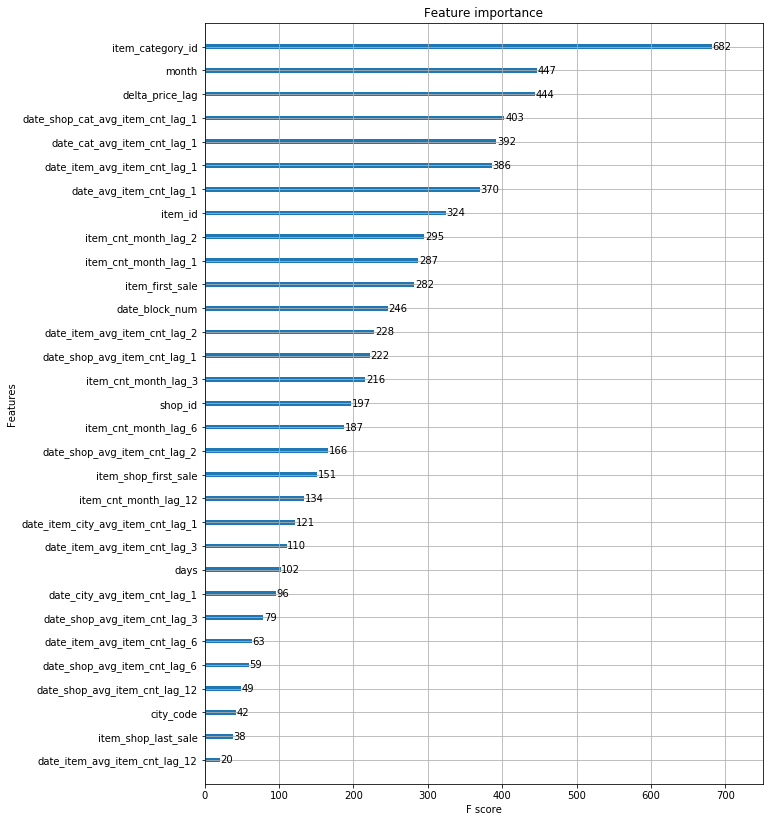

In [56]:
plot_features(model, (10,14))